In [2]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import json, requests
import pandas
from time import sleep
import pickle

%matplotlib inline

def getdata(deviceId):
    """Get data from server for particular device"""
    source = 'http://hello-linkerd-admin.eagleowl.online/query?db=example&q='
    #query = "SELECT \"value\" FROM example..sensor_data WHERE deviceId='%s' AND type='/temperature' AND time>now() - 60s" % deviceId
    query = "SELECT \"value\" FROM example..sensor_data WHERE deviceId='%s' AND type='/temperature' AND time>0" % deviceId
    url = source + query
    
    r = requests.get(url)
    j = r.json()
    dataout = j['results'][0]['series'][0]['values']
    return dataout


# Chicken coop temperature analysis

Here's a quick demo of loading the data and plotting it using GPy.

First we grab the temperature values from the sensors...

In [6]:
#res = []
#for deviceId in ['600194278c73','6001942787bf','6001941fcffd']:
#    try:
#        res.append(np.mean([float(x) for x in np.array(getdata(deviceId))[:,1]]))
#    except KeyError:
#        res.append(None)
#print(res)

In [27]:
res = [np.mean(np.array(r)[:,1].astype(np.float)) for r in pickle.load(open('chickendata.p','rb'))]

The three sensors are about the same temperature.

...and make a note of the sensors and bulb locations:

In [28]:
bulbs = np.array([[63,115,26],[67,188,11],[160,100,18],[247,195,25],[266,90,3],[358,147,21],[425,89,26],[470,188,18]])
sensors = np.array([[267,137,3],[99,180,3],[317,150,3]])

We believe the bulb distances to the sensors is important, so here we have a function that computes the sum of the inverse squares to the locations in X.

> The logic here is that the power from the bulb will be inverse square, so we should add up the powers from all the bulbs.

In [29]:
def invbulbdist(X,bulbs):
    """Get sum of inverse distances to the bulbs from X"""
    d = []
    for bulb in bulbs:
        d.append(1/(np.sum((X - bulb)**2,1)))
    return np.sum(np.array(d),0)*10000 #into 1/m^2, just to make things easier

Here we build the input and output training data, and optimise a GP model with a simple RBF kernel. Setting ARD to true means we think that the lengthscales for x, y and the distance to the bulbs will be different.

> Note we removed z as this isn't available in the training data (all the sensors are at the same height).

In [52]:
d = invbulbdist(sensors,bulbs)
X = np.c_[sensors[:,0:2],d] #removed z from X
y = np.array(res)[:,None]
k = GPy.kern.RBF(3,ARD=True) #x,y and bulb dist
m = GPy.models.GPRegression(X,y,k)
m.rbf.lengthscale[:] = 10.0
m.Gaussian_noise=0.1
m.rbf.variance = 10.0
m.optimize()

Quickly look at this model.

The training data input locations. The last axis is the sum of the inverse distances squared to the bulbs (added over all the bulbs). So it roughly is proportional to bulb power on the sensor.

In [53]:
X

array([[267.        , 137.        ,   9.85020508],
       [ 99.        , 180.        ,  12.3254817 ],
       [317.        , 150.        ,   9.6271681 ]])

In [54]:
m

GP_regression.,value,constraints,priors
rbf.variance,964.6513710557512,+ve,
rbf.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


We can look at what lengthscales the model chose. Quite long - which is probably due to a lack of information - only three training points!!

In [55]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],21771.46472677,+ve,
[1],3817.80970990,+ve,
[2],15413.10173325,+ve,


We build a matrix of test points...

In [56]:
x = np.arange(0,500,15)
y = np.arange(80,250,15)
z = 3
predX = np.meshgrid(x,y)

testX = np.c_[
predX[0].reshape([np.prod(predX[0].shape),1])[:,0],
predX[1].reshape([np.prod(predX[1].shape),1])[:,0]
]

tempa = np.c_[testX,np.ones([len(testX),1])*z]

d = invbulbdist(tempa,bulbs)
testX = np.c_[testX,d]

Ask for predictions at those test points

In [60]:
ypred,varpred = m.predict_noiseless(testX)

In [61]:
print("predictions range from %0.2f to %0.2f"%(np.min(ypred),np.max(ypred)))

predictions range from 26.82 to 28.59


In [62]:
print("uncertainty in predictions (std), is between %0.5f,%0.5f" % (np.sqrt(np.min(varpred)),np.sqrt(np.max(varpred))))

uncertainty in predictions (std), is between 0.00048,0.48075


Here we plot the results

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning:invalid value encountered in sqrt


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning:invalid value encountered in sqrt


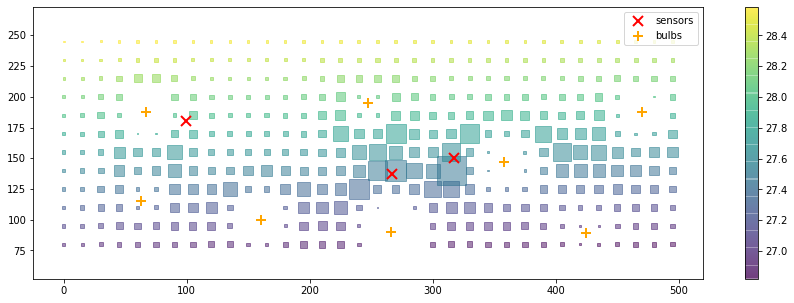

In [65]:
plt.figure(figsize=[15,5])
conf = 0.4*(1/np.sqrt(varpred) - 30)

im = plt.scatter(testX[:,0],testX[:,1],conf,c=ypred[:,0],marker='s',alpha=0.5)
plt.axis('equal')
#plt.clim([27.4,28.3])
plt.plot(sensors[:,0],sensors[:,1],'xr',markersize=10,mew=2,label='sensors')
plt.plot(bulbs[:,0],bulbs[:,1],'+',color='orange',markersize=10,mew=2,label='bulbs')
ax = plt.gca()
fig = plt.gcf()
plt.legend()
fig.colorbar(im)

In the plot above the size of the squares indicates our confidence in the estimates. The colour the temperature at that location.

A couple of observations :- the model thinks it knows something about the temperature. Only three sensors is a bit of a stretch for any prediction to use...!

Note the areas around each bulb without squares. This occurs as the GP is very non-confident in those areas as we have no sensors that close to the bulbs.

Ideally we'd leave one sensor out, and test the prediction driven by the other two sensors.